In [1]:
import os
from tqdm.notebook import tqdm
import glob
import sys
import time
import pickle
import cv2
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import random
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import get_scheduler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
BASE_DIR = './../Data/'

In [4]:
class CaptchaDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(f"{root_dir}{annotation_file}", dtype=str)
        # self.annotations = self.annotations[self.annotations['length']=='5']
        self.annotations = self.annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index]
        img = Image.open(
            # os.path.join( self.root_dir, 'NewDataset', 'data', img_id['category'], f"Len{img_id['length']}Char", img_id['file'])
            os.path.join( self.root_dir, 'NewDataset', f"Len{img_id['length']}Char", 'data', img_id['file'])
          ).convert("L")
        # print(img_id['length'], len(str(img_id['text'])))
        y_label = (int(img_id['length']), img_id['text']) #int(img_id['text'][1]), int(img_id['text'][2]), int(img_id['text'][3]), int(img_id['text'][4]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)
# class CaptchaDataset(Dataset):
#     def __init__(self, root_dir, annotation_file, transform=None):
#         self.root_dir = root_dir
#         self.annotations = pd.read_csv(f"./{annotation_file}", dtype=str)
#         self.transform = transform

#     def __len__(self):
#         return len(self.annotations)

#     def __getitem__(self, index):
#         img_id = self.annotations.iloc[index]
#         img = Image.open(
#             # os.path.join( self.root_dir, img_id['category'], f"Len{img_id['length']}Char", img_id['file'])
#             os.path.join( self.root_dir, img_id['file'])
#           ).convert("L")
#         # print('qwerty  ', img_id['text'])
#         y_label = (img_id['length'], str(img_id['text']))

#         if self.transform is not None:
#             img = self.transform(img)
  
#         return (img, y_label)

In [5]:
transform = transforms.Compose(
    [
        transforms.Resize((60, 200)),
        # transforms.RandomCrop((299, 299)),
        # transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
    ]
)

In [6]:
BATCH = 16

In [7]:
dataset = CaptchaDataset(BASE_DIR, "Num.csv", transform = transform)
print(len(dataset))
train_set, validation_set, test_set = torch.utils.data.random_split(dataset, [21000, 2000, 2000])
# train_set, validation_set = torch.utils.data.random_split(dataset, [8000,2001])

train_loader = DataLoader(dataset = train_set, shuffle = True, batch_size = BATCH)
validation_loader = DataLoader(dataset = validation_set, shuffle = True, batch_size = BATCH)
test_loader = DataLoader(dataset = test_set, shuffle = True, batch_size = BATCH)

25000


In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(type(labels[1]))

<class 'torch.Tensor'>
torch.Size([16, 1, 60, 200])
<class 'tuple'>


In [9]:
DROPOUT_PROB = 0.3

In [10]:
class Model(nn.Module):
    def __init__(self, dropout_flag=1):
        super().__init__()

        # self.dropout_flag = dropout_flag  # 1->Conv Layer, 2->FC Layer

        self.blockA = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
        )

        self.blockA_drop = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(DROPOUT_PROB),
        )

        self.blockB = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
        )

        self.blockB_drop = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(DROPOUT_PROB),
        )

        self.blockC = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
        )

        self.blockC_drop = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(DROPOUT_PROB),
        )


        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(11200, 512)
        self.out1 = nn.Linear(512, 11)
        self.out2 = nn.Linear(512, 11)
        self.out3 = nn.Linear(512, 11)
        self.out4 = nn.Linear(512, 11)
        self.out5 = nn.Linear(512, 11)

        self.length_out = nn.Linear(512, 5)

        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()

        # self.drop = nn.Dropout(DROPOUT_PROB)
        

    def forward(self, x):
        
        x = self.blockA(x)
        x = self.pool(x)
        
        x = self.blockB(x)
        x = self.pool(x)
        
        x = self.blockC_drop(x)
        x = self.pool(x)
        
        x = torch.flatten(x, start_dim=1)
        
        x = self.relu(self.fc1(x))

        label1 = self.out1(x)
        label2 = self.out2(x)
        label3 = self.out3(x)
        label4 = self.out4(x)
        label5 = self.out5(x)

        length = self.length_out(x)

        # return {'label1':label1, 'label2':label2, 'label3':label3, 'label4':label4, 'label5':label5}

        return {'label': torch.stack([label1, label2, label3, label4, label5], dim=1), 'length': length}

In [28]:
model = Model().to(device)

In [29]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [30]:
## create the default learning rate scheduler
num_epochs = 50
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    name="linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

In [34]:
def plot(trainlosslist, validationlosslist):
    epochs = range(1,50+1)
    plt.plot(epochs, trainlosslist, 'g', label='Training loss')
    plt.plot(epochs, validationlosslist, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [32]:
from torch.nn.utils.rnn import pad_sequence
# def train(model, title, regularization = None):
    
progress_bar = tqdm(range(num_training_steps))
trainlosslist = []
validationlosslist = []

for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct1 = 0
    train_correct2 = 0
    train_correct3 = 0
    train_correct4 = 0
    train_correct5 = 0
    train_correct = 0
    train_total = 0

    validation_loss = 0.0
    validation_correct1 = 0
    validation_correct2 = 0
    validation_correct3 = 0
    validation_correct4 = 0
    validation_correct5 = 0
    validation_correct = 0
    validation_total = 0

    model.train()
    for i, data in enumerate(train_loader):
        inputs = data[0].to(device)
        labels = data[1]
        
        label = []
        
        for l in range(len(labels[0])):
            label.append([])
            length = labels[0][l]

            for j in range(int(length)):
                character = labels[1][l][j]
                output_array = [0]*11
                output_array[int(character)] = 1
                label[l].append(output_array)

            for j in range(int(length), 5):
                output_array = [0]*11
                output_array[10] = 1
                label[l].append(output_array)

        label = torch.Tensor(label).to(device)
        outputs = model(inputs.to(device))

        # calculate loss
        loss_label = criterion(outputs['label'], label)

        # loss = loss #+ loss2 + loss3 + loss4 + loss5
        loss = loss_label

        pred = torch.argmax(outputs['label'], 2)
        
        label = torch.argmax(label, axis=2)

        train_correct += (torch.sum(label==pred, axis=1)==5).nonzero().shape[0]
        
        train_total += BATCH
        
        correct = torch.sum(label==pred, axis=0)

        train_correct1 += (correct[0])
        train_correct2 += (correct[1])
        train_correct3 += (correct[2])
        train_correct4 += (correct[3])
        train_correct5 += (correct[4])

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
        # print statistics
        train_loss += loss.item()


    model.eval()
    for i, data in (enumerate(validation_loader)):
        inputs = data[0].to(device)
        labels = data[1]
        
        label = []
        
        for l in range(len(labels[0])):
            label.append([])
            length = labels[0][l]

            for j in range(int(length)):
                character = labels[1][l][j]
                output_array = [0]*11
                output_array[int(character)] = 1
                label[l].append(output_array)

            for j in range(int(length), 5):
                output_array = [0]*11
                output_array[10] = 1
                label[l].append(output_array)

        label = torch.Tensor(label).to(device)
        outputs = model(inputs.to(device))

        # # calculate loss
        loss_label = criterion(outputs['label'], label)

        # # loss = loss #+ loss2 + loss3 + loss4 + loss5
        loss = loss_label

        pred = torch.argmax(outputs['label'], 2)
        
        label = torch.argmax(label, axis=2)

        validation_correct += (torch.sum(label==pred, axis=1)==5).nonzero().shape[0]
        
        validation_total += BATCH
        
        correct = torch.sum(label==pred, axis=0)
        
        validation_correct1 += (correct[0])
        validation_correct2 += (correct[1])
        validation_correct3 += (correct[2])
        validation_correct4 += (correct[3])
        validation_correct5 += (correct[4])
        validation_loss += loss.item()


    epoch_train_loss = train_loss/len(train_loader)
    epoch_train_acc1 = (train_correct1/train_total)*100
    epoch_train_acc2 = (train_correct2/train_total)*100
    epoch_train_acc3 = (train_correct3/train_total)*100
    epoch_train_acc4 = (train_correct4/train_total)*100
    epoch_train_acc5 = (train_correct5/train_total)*100

    print("Epoch [%d/%d]  Training Loss: %.5f  Acc1: %.5f  Acc2: %.5f  Acc3: %.5f  Acc4: %.5f  Acc5: %.5f " %(epoch+1, num_epochs, epoch_train_loss, epoch_train_acc1, epoch_train_acc2, epoch_train_acc3, epoch_train_acc4, epoch_train_acc5))
    print(f"Epoch {epoch},  Loss : {epoch_train_loss},  Acc : {train_correct/train_total}")


    epoch_validation_loss = validation_loss/len(validation_loader)
    epoch_validation_acc1 = (validation_correct1/validation_total)*100
    epoch_validation_acc2 = (validation_correct2/validation_total)*100
    epoch_validation_acc3 = (validation_correct3/validation_total)*100
    epoch_validation_acc4 = (validation_correct4/validation_total)*100
    epoch_validation_acc5 = (validation_correct5/validation_total)*100

    print("Epoch [%d/%d]  Validation Loss: %.5f  Acc1: %.5f  Acc2: %.5f  Acc3: %.5f  Acc4: %.5f  Acc5: %.5f " %(epoch+1, num_epochs, epoch_validation_loss, epoch_validation_acc1, epoch_validation_acc2, epoch_validation_acc3, epoch_validation_acc4, epoch_validation_acc5))
    print(f"Epoch {epoch},  Loss : {epoch_validation_loss},  Acc : {validation_correct/train_total}")
    
    trainlosslist.append(epoch_train_loss)
    validationlosslist.append(epoch_validation_loss)
    

print('Finished Training')

plot(trainlosslist, validationlosslist)

  0%|          | 0/65650 [00:00<?, ?it/s]

Epoch [1/50]  Training Loss: 0.64900  Acc1: 19.59730  Acc2: 7.92555  Acc3: 24.56683  Acc4: 55.95012  Acc5: 79.83626 
Epoch 0,  Loss : 0.6489976723504629,  Acc : 0.0009044173648134044
Epoch [1/50]  Validation Loss: 0.63453  Acc1: 19.20000  Acc2: 9.10000  Acc3: 42.25000  Acc4: 62.85001  Acc5: 80.55000 
Epoch 0,  Loss : 0.6345268688201904,  Acc : 0.0002856054836252856
Epoch [2/50]  Training Loss: 0.64215  Acc1: 20.20183  Acc2: 11.45278  Acc3: 39.82293  Acc4: 59.60587  Acc5: 79.89337 
Epoch 1,  Loss : 0.6421453270944856,  Acc : 0.006473724295506474
Epoch [2/50]  Validation Loss: 0.63956  Acc1: 19.20000  Acc2: 20.70000  Acc3: 42.25000  Acc4: 62.85001  Acc5: 80.55000 
Epoch 1,  Loss : 0.639558629989624,  Acc : 0.0018564356435643563
Epoch [3/50]  Training Loss: 0.63791  Acc1: 20.20183  Acc2: 8.78713  Acc3: 39.82293  Acc4: 59.60587  Acc5: 79.89337 
Epoch 2,  Loss : 0.6379130402777091,  Acc : 0.0026656511805026656
Epoch [3/50]  Validation Loss: 0.63484  Acc1: 19.20000  Acc2: 8.75000  Acc3: 42.2

Epoch [24/50]  Training Loss: 0.63350  Acc1: 20.20183  Acc2: 19.99714  Acc3: 39.82293  Acc4: 59.60587  Acc5: 79.89337 
Epoch 23,  Loss : 0.6334973254552436,  Acc : 0.019611576542269613
Epoch [24/50]  Validation Loss: 0.63359  Acc1: 19.20000  Acc2: 20.70000  Acc3: 42.25000  Acc4: 62.85001  Acc5: 80.55000 
Epoch 23,  Loss : 0.6335910320281982,  Acc : 0.0018564356435643563
Epoch [25/50]  Training Loss: 0.63413  Acc1: 20.20183  Acc2: 19.99714  Acc3: 39.82293  Acc4: 59.60587  Acc5: 79.89337 
Epoch 24,  Loss : 0.6341285096809143,  Acc : 0.019611576542269613
Epoch [25/50]  Validation Loss: 0.63213  Acc1: 19.20000  Acc2: 20.70000  Acc3: 42.25000  Acc4: 62.85001  Acc5: 80.55000 
Epoch 24,  Loss : 0.632130952835083,  Acc : 0.0018564356435643563
Epoch [26/50]  Training Loss: 0.63430  Acc1: 20.20183  Acc2: 19.99714  Acc3: 39.82293  Acc4: 59.60587  Acc5: 79.89337 
Epoch 25,  Loss : 0.6342965353107235,  Acc : 0.019611576542269613
Epoch [26/50]  Validation Loss: 0.63488  Acc1: 19.20000  Acc2: 20.7000

Epoch [46/50]  Training Loss: 0.63249  Acc1: 20.20183  Acc2: 19.99714  Acc3: 39.82293  Acc4: 59.60587  Acc5: 79.89337 
Epoch 45,  Loss : 0.63248781942722,  Acc : 0.019611576542269613
Epoch [46/50]  Validation Loss: 0.63116  Acc1: 19.20000  Acc2: 20.70000  Acc3: 42.25000  Acc4: 62.85001  Acc5: 80.55000 
Epoch 45,  Loss : 0.6311573238372803,  Acc : 0.0018564356435643563
Epoch [47/50]  Training Loss: 0.63244  Acc1: 20.20183  Acc2: 19.99714  Acc3: 39.82293  Acc4: 59.60587  Acc5: 79.89337 
Epoch 46,  Loss : 0.6324427615842653,  Acc : 0.019611576542269613
Epoch [47/50]  Validation Loss: 0.63135  Acc1: 19.20000  Acc2: 20.70000  Acc3: 42.25000  Acc4: 62.85001  Acc5: 80.55000 
Epoch 46,  Loss : 0.6313480515480041,  Acc : 0.0018564356435643563
Epoch [48/50]  Training Loss: 0.63240  Acc1: 20.20183  Acc2: 19.99714  Acc3: 39.82293  Acc4: 59.60587  Acc5: 79.89337 
Epoch 47,  Loss : 0.6323984874538674,  Acc : 0.019611576542269613
Epoch [48/50]  Validation Loss: 0.63139  Acc1: 19.20000  Acc2: 20.70000

NameError: name 'N_EPOCHS' is not defined

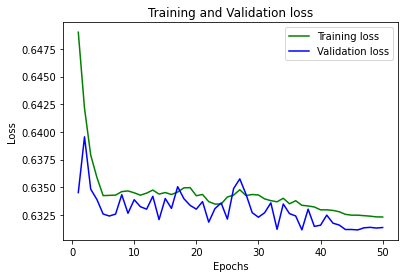

In [35]:
plot(trainlosslist, validationlosslist)

In [17]:
model.eval()
for i, data in tqdm(enumerate(validation_loader)):
    inputs = data[0].to(device)
    labels = data[1]
    
    label = []
    
    for l in range(len(labels[0])):
        label.append([])
        length = labels[0][l]

        for j in range(int(length)):
            character = labels[1][l][j]
            output_array = [0]*10
            output_array[int(character)] = 1
            label[l].append(output_array)

        for j in range(int(length), 5):
            output_array = [0]*10
            output_array[10] = 1
            label[l].append(output_array)

    label = torch.Tensor(label).to(device)
    outputs = model(inputs.to(device))

    # # calculate loss
    # loss_label = criterion(outputs['label'], label)

    # # loss = loss #+ loss2 + loss3 + loss4 + loss5
    # loss = loss_label

    pred = torch.argmax(outputs['label'], 2)
    
    label = torch.argmax(label, axis=2)

    train_correct += (torch.sum(label==pred, axis=1)==5).nonzero().shape[0]
    
    train_total += BATCH
    
    correct = torch.sum(label==pred, axis=0)
    
    train_correct1 += (correct[0])
    train_correct2 += (correct[1])
    train_correct3 += (correct[2])
    train_correct4 += (correct[3])
    train_correct5 += (correct[4])

epoch_train_loss = train_loss/len(train_loader)
# epoch_validation_loss = validation_loss/len(validation_loader) 
epoch_train_acc1 = (train_correct1/train_total)*100
epoch_train_acc2 = (train_correct2/train_total)*100
epoch_train_acc3 = (train_correct3/train_total)*100
epoch_train_acc4 = (train_correct4/train_total)*100
epoch_train_acc5 = (train_correct5/train_total)*100
# epoch_validation_acc = (validation_correct1/validation_total)*100

print("Epoch [%d/%d]  Validation Loss: %.5f  Acc1: %.5f  Acc2: %.5f  Acc3: %.5f  Acc4: %.5f  Acc5: %.5f " %(epoch+1, num_epochs, epoch_train_loss, epoch_train_acc1, epoch_train_acc2, epoch_train_acc3, epoch_train_acc4, epoch_train_acc5))
print(f"Epoch {epoch},  Loss : {epoch_train_loss},  Acc : {train_correct/train_total}")


0it [00:00, ?it/s]

IndexError: list assignment index out of range